# Fully Convolutional Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno

import numpy as np

import deepcell

In [53]:
train_dict = np.load(NPZ_DIR + npz_name)

In [54]:
X_train, y_train = train_dict['X'], train_dict['y']

In [55]:
cell_counts = []
for i in range(y_train.shape[0]):
    unique = len(np.unique(y_train[i, :, :, 0]))
    cell_counts.append(unique)

In [56]:
nuc_counts = []
for i in range(y_train.shape[0]):
    unique = len(np.unique(X_train[i, :, :, 0]))
    nuc_counts.append(unique)

In [57]:
memb_counts = []
for i in range(y_train.shape[0]):
    unique = len(np.unique(X_train[i, :, :, 1]))
    memb_counts.append(unique)

In [61]:
np.sum(np.array(memb_counts) > 1)

2669

In [58]:
y_train.shape

(2670, 256, 256, 1)

In [62]:
sparse_idx = np.array(cell_counts) > 2
nuc_idx = np.array(nuc_counts) > 2
memb_idx = np.array(memb_counts) > 2

In [63]:
total_idx = sparse_idx * nuc_idx * memb_idx

In [64]:
np.savez_compressed(NPZ_DIR + npz_name, X=X_train[total_idx], y=y_train[total_idx])

### Load the training data

In [2]:
# create folder for this set of experiments
experiment_folder = "featurenet"
MODEL_DIR = os.path.join("/data/analyses", experiment_folder)
NPZ_DIR = "/data/npz_data/20201018_freeze/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

### Set up filepath constants

### Set up training parameters

In [3]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

model = '3'

conv_model_name = 'featurenet_split_{}_redo'.format(model)
npz_name = "20201018_multiplex_seed_{}_train_256x256.npz".format(model)
DATA_FILE = os.path.join(NPZ_DIR, npz_name)

n_epoch = 25  # Number of training epochs
norm_method = None  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'pixelwise'
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = False  # break edges into cell-background edge, cell-cell edge
n_features = 4 if separate_edge_classes else 3

### Next, Create a model for the edge/interior segmentation

#### Instantiate the segmentation transform model

In [4]:
from deepcell import model_zoo

conv_model = model_zoo.bn_feature_net_skip_2D(
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=(256, 256, 2))

W1115 03:11:12.391070 140369887557440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### Train the segmentation transform model

In [5]:
from deepcell.training import train_model_conv

conv_model = train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=conv_model_name,
    test_size=0.1,
    seed=1,
    transform=transform,
    dilation_radius=dilation_radius,
    separate_edge_classes=separate_edge_classes,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.7, 1/0.7))

X_train shape: (2384, 256, 256, 2)
y_train shape: (2384, 256, 256, 1)
X_test shape: (265, 256, 256, 2)
y_test shape: (265, 256, 256, 1)
Output Shape: (None, 256, 256, 3)
Number of Classes: 3
Training on 1 GPUs
Epoch 1/25


W1115 03:11:51.598669 140369887557440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


   1/2384 [..............................] - ETA: 7:34:05 - loss: 5.5636 - model_loss: 1.3106 - model_1_loss: 1.4279 - model_2_loss: 1.4038 - model_3_loss: 1.3852 - model_acc: 0.2765 - model_1_acc: 0.4211 - model_2_acc: 0.1967 - model_3_acc: 0.1994

W1115 03:12:02.653802 140369887557440 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.224747). Check your callbacks.


2383/2384 [============================>.] - ETA: 0s - loss: 3.0129 - model_loss: 0.7618 - model_1_loss: 0.7537 - model_2_loss: 0.7374 - model_3_loss: 0.7222 - model_acc: 0.6397 - model_1_acc: 0.6364 - model_2_acc: 0.6503 - model_3_acc: 0.6583
Epoch 00001: val_loss improved from inf to 3.17922, saving model to /data/analyses/featurenet/featurenet_split_3_redo.h5
2384/2384 [==============================] - 323s 135ms/step - loss: 3.0127 - model_loss: 0.7617 - model_1_loss: 0.7536 - model_2_loss: 0.7374 - model_3_loss: 0.7222 - model_acc: 0.6397 - model_1_acc: 0.6365 - model_2_acc: 0.6504 - model_3_acc: 0.6583 - val_loss: 3.1792 - val_model_loss: 0.8149 - val_model_1_loss: 0.8162 - val_model_2_loss: 0.7520 - val_model_3_loss: 0.7580 - val_model_acc: 0.7099 - val_model_1_acc: 0.6992 - val_model_2_acc: 0.7000 - val_model_3_acc: 0.7048
Epoch 2/25
2383/2384 [============================>.] - ETA: 0s - loss: 2.6731 - model_loss: 0.6667 - model_1_loss: 0.6626 - model_2_loss: 0.6550 - model_3_

2383/2384 [============================>.] - ETA: 0s - loss: 2.3164 - model_loss: 0.5769 - model_1_loss: 0.5676 - model_2_loss: 0.5658 - model_3_loss: 0.5648 - model_acc: 0.7531 - model_1_acc: 0.7620 - model_2_acc: 0.7611 - model_3_acc: 0.7616
Epoch 00011: val_loss did not improve from 2.74173
2384/2384 [==============================] - 303s 127ms/step - loss: 2.3165 - model_loss: 0.5770 - model_1_loss: 0.5676 - model_2_loss: 0.5659 - model_3_loss: 0.5649 - model_acc: 0.7531 - model_1_acc: 0.7620 - model_2_acc: 0.7611 - model_3_acc: 0.7615 - val_loss: 2.8521 - val_model_loss: 0.7140 - val_model_1_loss: 0.7238 - val_model_2_loss: 0.6761 - val_model_3_loss: 0.6969 - val_model_acc: 0.7388 - val_model_1_acc: 0.7288 - val_model_2_acc: 0.7412 - val_model_3_acc: 0.7269
Epoch 12/25
2383/2384 [============================>.] - ETA: 0s - loss: 2.3085 - model_loss: 0.5750 - model_1_loss: 0.5656 - model_2_loss: 0.5642 - model_3_loss: 0.5624 - model_acc: 0.7553 - model_1_acc: 0.7631 - model_2_acc:

2384/2384 [==============================] - 303s 127ms/step - loss: 2.2246 - model_loss: 0.5566 - model_1_loss: 0.5434 - model_2_loss: 0.5420 - model_3_loss: 0.5398 - model_acc: 0.7652 - model_1_acc: 0.7731 - model_2_acc: 0.7729 - model_3_acc: 0.7736 - val_loss: 2.5876 - val_model_loss: 0.6139 - val_model_1_loss: 0.6272 - val_model_2_loss: 0.6688 - val_model_3_loss: 0.6348 - val_model_acc: 0.7493 - val_model_1_acc: 0.7611 - val_model_2_acc: 0.7550 - val_model_3_acc: 0.7619
Epoch 22/25
2383/2384 [============================>.] - ETA: 0s - loss: 2.2348 - model_loss: 0.5585 - model_1_loss: 0.5462 - model_2_loss: 0.5444 - model_3_loss: 0.5427 - model_acc: 0.7652 - model_1_acc: 0.7738 - model_2_acc: 0.7734 - model_3_acc: 0.7739
Epoch 00022: val_loss did not improve from 2.58759
2384/2384 [==============================] - 303s 127ms/step - loss: 2.2345 - model_loss: 0.5585 - model_1_loss: 0.5461 - model_2_loss: 0.5443 - model_3_loss: 0.5426 - model_acc: 0.7652 - model_1_acc: 0.7738 - mode

### Run the model

#### Make predictions on test data

In [10]:
test_images = conv_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1440, 216, 256, 4)
segmentation mask shape: (1440, 216, 256, 2)


#### Post-processing

In [11]:
# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

test_images_post_fgbg = test_images * fg_thresh

In [12]:
# Label interior predictions
from skimage.measure import label
from skimage import morphology

labeled_images = []
for i in range(test_images_post_fgbg.shape[0]):
    interior = test_images_post_fgbg[i, ..., 2] > .2
    labeled_image = label(interior)
    labeled_image = morphology.remove_small_objects(
        labeled_image, min_size=50, connectivity=1)
    labeled_images.append(labeled_image)
labeled_images = np.array(labeled_images)
labeled_images = np.expand_dims(labeled_images, axis=-1)

print('labeled_images shape:', labeled_images.shape)

/usr/local/lib/python3.5/dist-packages/skimage/morphology/misc.py:132: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


labeled_images shape: (1440, 216, 256, 1)


Image number: 109


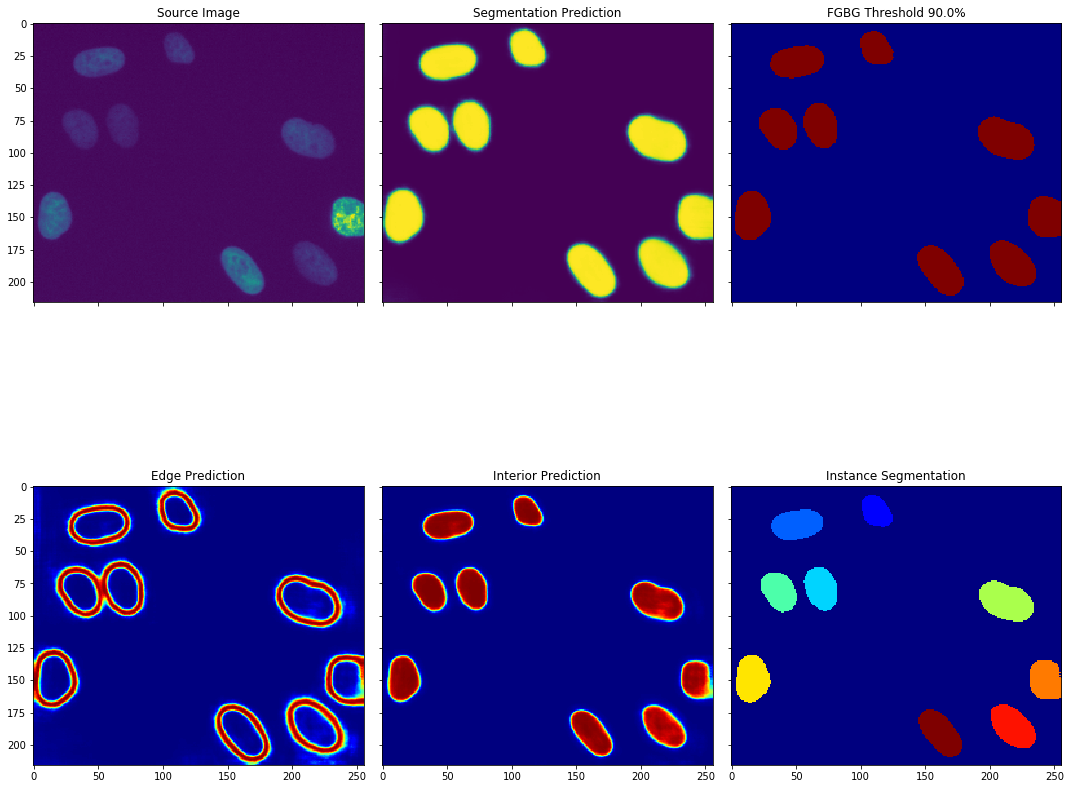

In [17]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(test_images[index, ..., 0] + test_images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(test_images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(labeled_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')

fig.tight_layout()
plt.show()